<a href="https://colab.research.google.com/github/tvml/ml2324/blob/master/codici/fashion-mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Multilayer Perceptrons from Scratch 

From https://d2l.ai

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import seaborn as sn
from pylab import subplot,imshow,NullLocator
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchinfo import summary

cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.35, 0.95, 256)))

In [2]:
torch.__version__

'1.11.0'

In [3]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#5D80AE', '#FC5758', '#0DD77D', '#FFC507', '#F64044', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

In [4]:
class History:
    """Accumulates values in a dictionary of sequences."""
    def __init__(self, keys):
        self.data = {}
        self.keys = keys
        for k in self.keys:
            self.data[k] = []

    def add(self, *args):
        for k,a in zip(self.keys, args):
            self.data[k].append(a)

    def sums(self):
        return {k: sum(self.data[k]) for k in self.keys}

    def merge(self, d):
        for k in self.keys:
            self.data[k].extend(d[k])

    def __getitem__(self, k):
        return self.data

In [5]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [6]:
def get_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    return [text_labels[int(i)] for i in labels]


def displayData(X, t, rows=10, cols=10, img_ind=None, size =8, class_value = False):
    X = X.numpy()
    t = t.numpy()
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 10, color=colors[4])
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off') 
    plt.subplots_adjust(top=1)
    plt.show()


def plotData(X, Y, c, npixel=28):
    X = X.numpy()
    m, n = X.shape
    image = np.array(X[c,:])
    plt.figure(figsize = (6,6))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='quadric')
    plt.show()


def save_model_coeffs(m,filename):
    torch.save(m.state_dict(), filename)
    print("Saved model coefficients to disk")


def load_model_coeffs(m, filename):
    m.load_state_dict(torch.load(filename))
    print("Model coefficients loaded from disk")

In [7]:
def accuracy(preds, targets):  #@save
    """Compute the number of correct predictions."""
    # deal with the case when an array of probabilities is predict, by deriving the highest-probability class
    if len(preds.shape) > 1 and preds.shape[1] > 1:
        preds = preds.argmax(axis=1)
    cmp = preds.type(targets.dtype) == targets
    return float(cmp.type(targets.dtype).sum())


def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        # Set the model to eval mode
        net.eval()
    h_test = History(['correct_predictions', 'predictions'])  # No. of correct predictions, no. of predictions
    with torch.no_grad(): # Gradients must not be computed
        count = 0
        for X, y in data_iter:
            count += 1
            if count%10 == 0:
                print('x', end='')
            #X = X.flatten(start_dim=1, end_dim=-1)
            h_test.add(accuracy(net(X), y), len(y))
        s = h_test.sums()
    print(' ')
    return s['correct_predictions']/s['predictions']


def train_epoch(model, train_iter, loss_func, optimizer): 
    if isinstance(model, torch.nn.Module):
        model.train()  # Set the model to training mode
    h_epoch = History(['loss', 'correct_predictions', 'n_examples']) # Training loss, no. of correct predictions, no. of examples
    count = 0
    for X, y in train_iter:
        count += 1
        if count%10 == 0:
            print('.', end='')
        #X=X.flatten(start_dim=1, end_dim=-1)
        # Compute predictions
        y_hat = model(X)
        # Compute loss
        loss = loss_func(y_hat, y)
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        h_epoch.add(float(loss), accuracy(y_hat, y), len(y))
    # Return training loss and training accuracy
    s = h_epoch.sums()
    return s['loss']/s['n_examples'], s['correct_predictions']/s['n_examples'], h_epoch


def train(net, loaders, loss_func, num_epochs, updater, report=False):
    h_batch = History(['loss', 'correct_predictions', 'n_examples'])
    h_train = History(['training_loss', 'training_accuracy', 'test_accuracy']) # Avg. training loss, avg. training accuracy, test accuracy
    for epoch in range(num_epochs):
        print(f'Epoch #{epoch+1}')
        # train model for one epoch
        train_loss, train_acc, h_epoch = train_epoch(net, loaders['train'], loss_func, updater)
        # evaluate accuracy on test set
        test_acc = evaluate_accuracy(net, loaders['test'])
        if report:
            print(f' Loss {train_loss:3.4f}, Training set accuracy {train_acc:1.4f}, Test set accuracy {test_acc:1.4f}')
        else:
            print('\n')
        h_train.add(train_loss, train_acc, test_acc)
        h_batch.merge(h_epoch.data)
    return h_train, h_batch


def predict(net, loaders):
    preds_train = []
    y_train = []
    preds_test = []
    y_test = []
    if isinstance(net, torch.nn.Module):
        net.eval()
    with torch.no_grad():
        for X, y in loaders['train']:
            #X = X.flatten(start_dim=1, end_dim=-1)
            preds = (torch.max(net(X),1)[1]).numpy()
            preds_train.extend(preds)
            y_train.extend(y.numpy())
        for X, y in loaders['test']:
            #X = X.flatten(start_dim=1, end_dim=-1)
            preds = (torch.max(net(X),1)[1]).numpy()
            preds_test.extend(preds)
            y_test.extend(y.numpy())
    return preds_train, y_train, preds_test, y_test

In [8]:
def plot_metrics(title, h, hb):
    losses = []
    accs = []
    for l, c, n in zip(hb.data['loss'], hb.data['correct_predictions'], hb.data['n_examples']):
        losses.append(l/n)
        accs.append(c/n)
    n = len(accs)
    step = int(n/num_epochs)
    xs = range(step-1, n+step-1, step)

    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
    ax1.plot(range(len(losses)),losses, color= colors[0], lw=.5, label='Loss by batch', zorder=2)
    ax1.scatter(xs, h.data['training_loss'], color=colors[1], edgecolors='black', label='Loss by epoch', zorder=2)
    for x in xs:
        ax1.axvline(x, lw=1, color='gray', zorder=1)
    ax1.legend()
    ax1.set_title('Loss')
    ax2.plot(range(len(accs)),accs, color= colors[0], lw=.5, label='Training set accuracy by batch', zorder=2)
    ax2.scatter(xs, h.data['training_accuracy'], color=colors[1], edgecolors='black', label='Training set accuracy by epoch', zorder=2)
    ax2.scatter(xs, h.data['test_accuracy'], color=colors[2], edgecolors='black', label='Test set accuracy by epoch', zorder=2)
    for x in xs:
        ax2.axvline(x, lw=1, color='gray', zorder=1)
    ax2.legend()
    ax2.set_title('Accuracy')
    plt.suptitle(title)
    plt.show()


def plot_label_dist(predictions_probs, predicted_class, true_label):
      plt.figure(figsize = (4,4))
      thisplot = plt.bar(range(10), predictions_probs, color="#77aaaa")
      plt.ylim([0, 1]) 
      thisplot[predicted_class].set_color(colors[0])
      thisplot[true_label].set_edgecolor(colors[4])
      thisplot[true_label].set_linewidth(1)
      plt.grid(False)
      plt.xticks(range(10))
      plt.yticks([])
      plt.show()

In [9]:
trans = ToTensor()
f_mnist_train = datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
f_mnist_test = datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

In [10]:
print(f'Training set features: n={f_mnist_train.data.numpy().shape[0]}, h={f_mnist_train.data.numpy().shape[1]}, w={f_mnist_train.data.numpy().shape[2]}')
print(f'Training set targets: n={f_mnist_train.targets.numpy().shape[0]}')

Training set features: n=60000, h=28, w=28
Training set targets: n=60000


In [10]:
print(f'Test set features: n={f_mnist_test.data.numpy().shape[0]}, h={f_mnist_test.data.numpy().shape[1]}, w={f_mnist_test.data.numpy().shape[2]}')
print(f'Test set targets: n={f_mnist_test.targets.numpy().shape[0]}')

Test set features: n=10000, h=28, w=28
Test set targets: n=10000


In [98]:
print(f_mnist_train.data[0,:,:])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
           0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
         102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

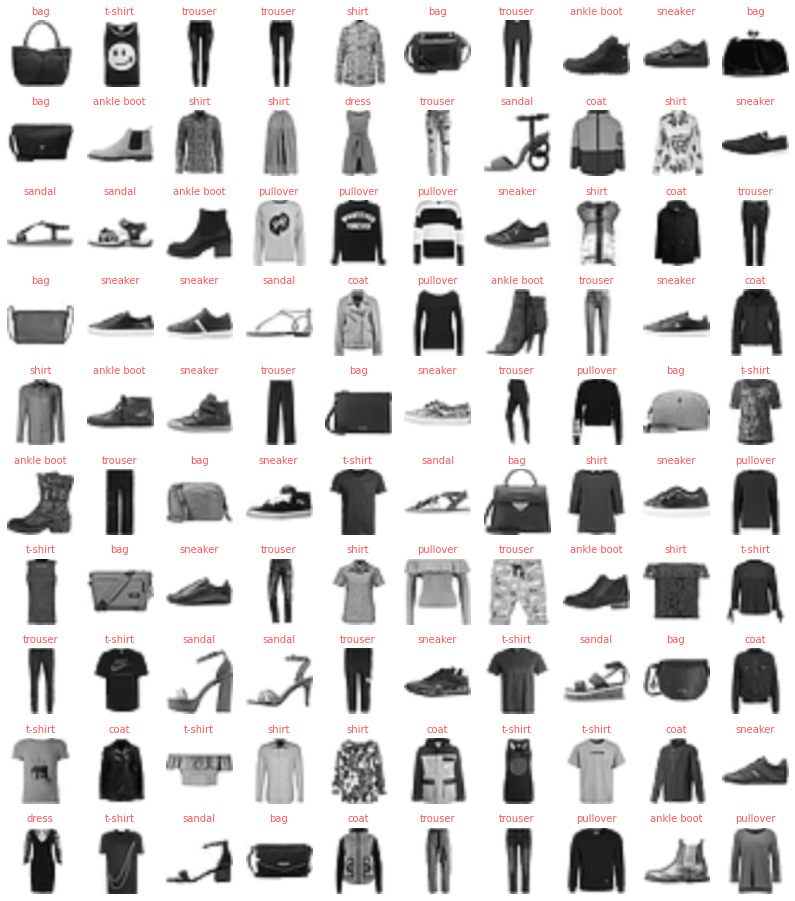

In [11]:
displayData(f_mnist_train.data[100:200], f_mnist_train.targets[100:200], class_value=True)

In [11]:
height = f_mnist_train.data.shape[1]
width = f_mnist_train.data.shape[2]
num_classes = f_mnist_train.targets.unique().shape[0]

In [12]:
batch_size = 100

loaders = {'train' : DataLoader(f_mnist_train, batch_size=batch_size, shuffle=True),
            'test'  : DataLoader(f_mnist_test, batch_size=batch_size, shuffle=True)}


## Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
Again, we will disregard the spatial structure
among the pixels for now,
so we can think of this as simply a classification dataset
with 784 input features and 10 classes.
To begin, we will implement an MLP
with one hidden layer and 256 hidden units.
Note that we can regard both of these quantities
as hyperparameters.
Typically, we choose layer widths in powers of 2,
which tend to be computationally efficient because
of how memory is allocated and addressed in hardware.

Parameters are represented as tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
We also allocate memory
for the gradients of the loss with respect to these parameters.


In [13]:
input_size =  height*width
num_outputs = num_classes


In [15]:
class MLP3(nn.Module):
    def __init__(self, h, w, hidden_size, num_classes):
        super(MLP3, self).__init__()
        self.f = nn.Flatten()
        self.l1 = nn.Linear(w*h, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.ls = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.f(x)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.ls(out)
        return out

In [16]:
hidden_size = 512
net = MLP3(height, width, hidden_size, num_classes)

In [17]:
summary(net, input_size=(batch_size, height*width))

Layer (type:depth-idx)                   Output Shape              Param #
MLP3                                     [100, 10]                 --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 512]                401,920
├─ReLU: 1-3                              [100, 512]                --
├─Linear: 1-4                            [100, 10]                 5,130
├─LogSoftmax: 1-5                        [100, 10]                 --
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
Total mult-adds (M): 40.70
Input size (MB): 0.31
Forward/backward pass size (MB): 0.42
Params size (MB): 1.63
Estimated Total Size (MB): 2.36

In [18]:
learning_rate = 0.01

loss_func = nn.NLLLoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [19]:
num_epochs = 3
h, h_batch = train(net, loaders, loss_func, num_epochs, optimizer, report=True)

Epoch #1
............................................................xxxxxxxxxx 
 Loss 0.5229, Training set accuracy 0.8178, Test set accuracy 0.8401
Epoch #2
............................................................xxxxxxxxxx 
 Loss 0.3880, Training set accuracy 0.8600, Test set accuracy 0.8549
Epoch #3
............................................................xxxxxxxxxx 
 Loss 0.3614, Training set accuracy 0.8672, Test set accuracy 0.8674


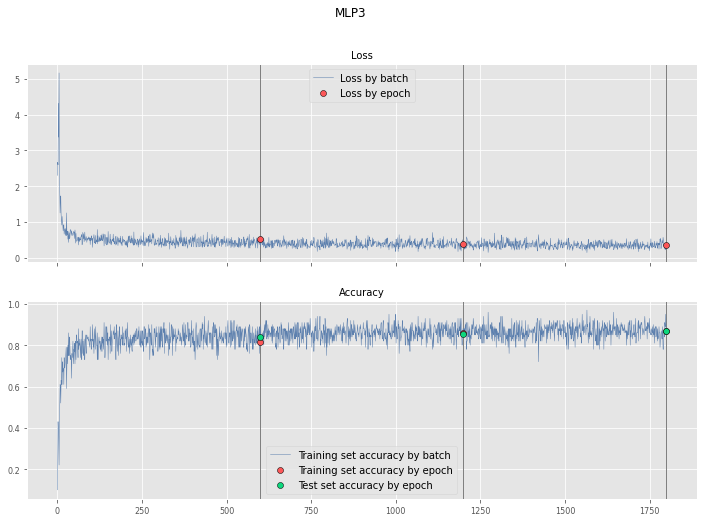

In [20]:
plot_metrics('MLP3', h, h_batch)

In [21]:
ptr, ytr, pte, yte = predict(net, loaders)

<Figure size 864x432 with 0 Axes>

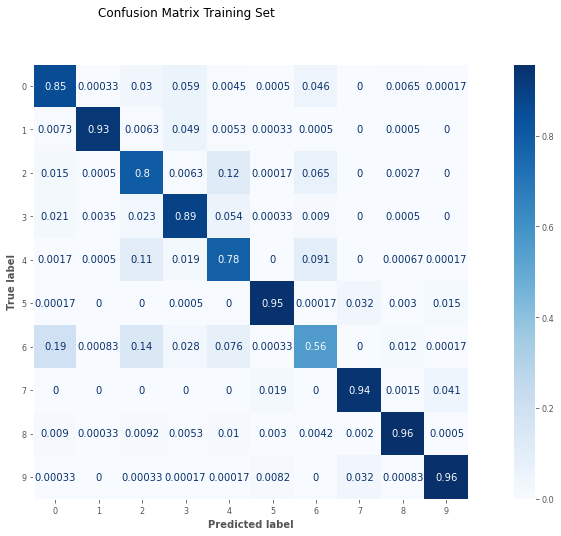

In [35]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()

In [36]:
print('Training set')
print(classification_report(ytr, ptr))

Training set
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      6000
           1       0.99      0.93      0.96      6000
           2       0.72      0.80      0.76      6000
           3       0.84      0.89      0.86      6000
           4       0.75      0.78      0.76      6000
           5       0.97      0.95      0.96      6000
           6       0.72      0.56      0.63      6000
           7       0.93      0.94      0.94      6000
           8       0.97      0.96      0.96      6000
           9       0.94      0.96      0.95      6000

    accuracy                           0.86     60000
   macro avg       0.86      0.86      0.86     60000
weighted avg       0.86      0.86      0.86     60000



<Figure size 864x432 with 0 Axes>

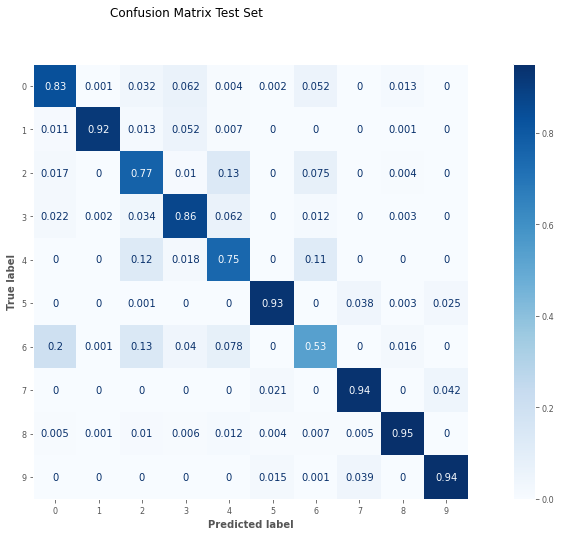

In [37]:

plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()

In [75]:
print('Test set')
print(classification_report(yte, pte))

Test set
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.81      0.80      1000
           3       0.87      0.90      0.88      1000
           4       0.78      0.82      0.80      1000
           5       0.98      0.95      0.96      1000
           6       0.75      0.65      0.70      1000
           7       0.93      0.96      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



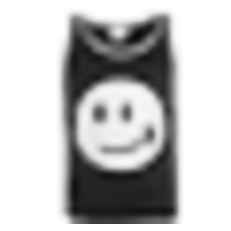

In [28]:
idx = 101
x = trans(f_mnist_train.data[idx,:,:].numpy())#.flatten(start_dim=0, end_dim=-1)
y = f_mnist_train.targets[idx].numpy()
image = f_mnist_train.data[idx,:,:].numpy()
plt.figure(figsize = (4,4))
plt.imshow(image, cmap='Greys', interpolation='quadric')
plt.grid(None)
plt.axis('off')
plt.show()

In [29]:
print(f"This is a {text_labels[y]}")

This is a t-shirt


In [30]:
predict0 = net(x)

predictions_probs = torch.exp(predict0).detach().squeeze()
predicted_class = np.squeeze(np.argmax(predictions_probs, axis=-1))
print("Predicted probabilities: ["+", ".join('%5.4f'%x for x in predictions_probs)+"]")
print(f"Class: {text_labels[y]}. Prediction: {text_labels[predicted_class]}")

Predicted probabilities: [0.1777, 0.0002, 0.0183, 0.2928, 0.0008, 0.0001, 0.5100, 0.0000, 0.0003, 0.0000]
Class: t-shirt. Prediction: shirt


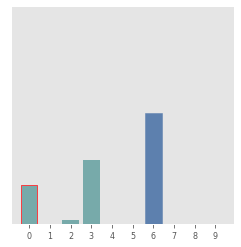

In [31]:
plot_label_dist(predictions_probs, predicted_class, y)